# Predicting NBA Game Outcomes

## Uploading Dataset

In [162]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU

In [163]:
# Show all cols in df.head()
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Revert to some cols
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')

### Injuries Dataset

In [164]:
injuries = pd.read_csv('data/injury.csv')

In [165]:
print(injuries.shape)
injuries.head()

(37667, 6)


,Unnamed: 0,Date,Team,Acquired,Relinquished,Notes
0,0,1951-12-25,Bullets,NaN,Don Barksdale,placed on IL
1,1,1952-12-26,Knicks,NaN,Max Zaslofsky,placed on IL with torn side muscle
2,2,1956-12-29,Knicks,NaN,Jim Baechtold,placed on inactive list
3,3,1959-01-16,Lakers,NaN,Elgin Baylor,player refused to play after being denied a ro...
4,4,1961-11-26,Lakers,NaN,Elgin Baylor,player reported for military duty


### Rankings Dataset

In [166]:
rankings = pd.read_csv('data/ranking.csv', on_bad_lines='skip')

In [167]:
print(rankings.shape)
rankings.head()

(210342, 13)


,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612743,0,22022,2022-12-22,West,Denver,30,19,11,0.633,10-3,9-8,NaN
1,1610612763,0,22022,2022-12-22,West,Memphis,30,19,11,0.633,13-2,6-9,NaN
2,1610612740,0,22022,2022-12-22,West,New Orleans,31,19,12,0.613,13-4,6-8,NaN
3,1610612756,0,22022,2022-12-22,West,Phoenix,32,19,13,0.594,14-4,5-9,NaN
4,1610612746,0,22022,2022-12-22,West,LA Clippers,33,19,14,0.576,11-7,8-7,NaN


In [168]:
print(rankings['STANDINGSDATE'].min())

2003-10-01


### Games Dataset

In [169]:
games = pd.read_csv('data/game.csv', on_bad_lines='skip')

In [170]:
print(games.shape)
games.head()

(65698, 55)


,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
0,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,NaN,NaN,NaN,NaN,NaN,16.0,29.0,0.552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,-2,0,1610612752,NYK,New York Knicks,NYK @ HUS,W,24.0,NaN,NaN,NaN,NaN,NaN,20.0,26.0,0.769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,2,0,Regular Season
1,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,59.0,0.339,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,56.0,5,0,1610610031,PIT,Pittsburgh Ironmen,PIT @ BOM,L,16.0,72.0,0.222,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,51.0,-5,0,Regular Season
2,21946,1610610032,PRO,Providence Steamrollers,24600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,6,0,1610612738,BOS,Boston Celtics,BOS @ PRO,L,21.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,-6,0,Regular Season
3,21946,1610610025,CHS,Chicago Stags,24600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,63.0,16,0,1610612752,NYK,New York Knicks,NYK @ CHS,L,16.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,47.0,-16,0,Regular Season
4,21946,1610610028,DEF,Detroit Falcons,24600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,-17,0,1610610036,WAS,Washington Capitols,WAS @ DEF,W,18.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,17,0,Regular Season


In [ ]:
# temp col to see team names
# print(games['team_abbreviation_home'].unique())
# print(games['team_name_home'].unique())

In [ ]:
# temp to find sample sets



# ---------------------

# # filtered_df = games[games['team_name_home'] == 'Washington Wizards']
# # sample = filtered_df.sample(n=1)
# # print(sample)

# filtered_df = games[games['team_abbreviation_home'] == 'NOP']
# sample = filtered_df.sample(n=1)
# print(sample)

## Preprocessing

### Injuries Dataset

Renaming columns for easier access (lowercase names). Converting dates to datetime and adding year as feature.

In [171]:
injuries.drop(['Unnamed: 0'], axis=1, inplace=True)
injuries = injuries.rename(columns={"Date": "date", "Team": "team", "Acquired": "acquired", "Relinquished": "relinquished", "Notes": "notes"})
injuries['date'] = pd.to_datetime(injuries['date'])

[1951 1952 1956 1959 1961 1962 1965 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]


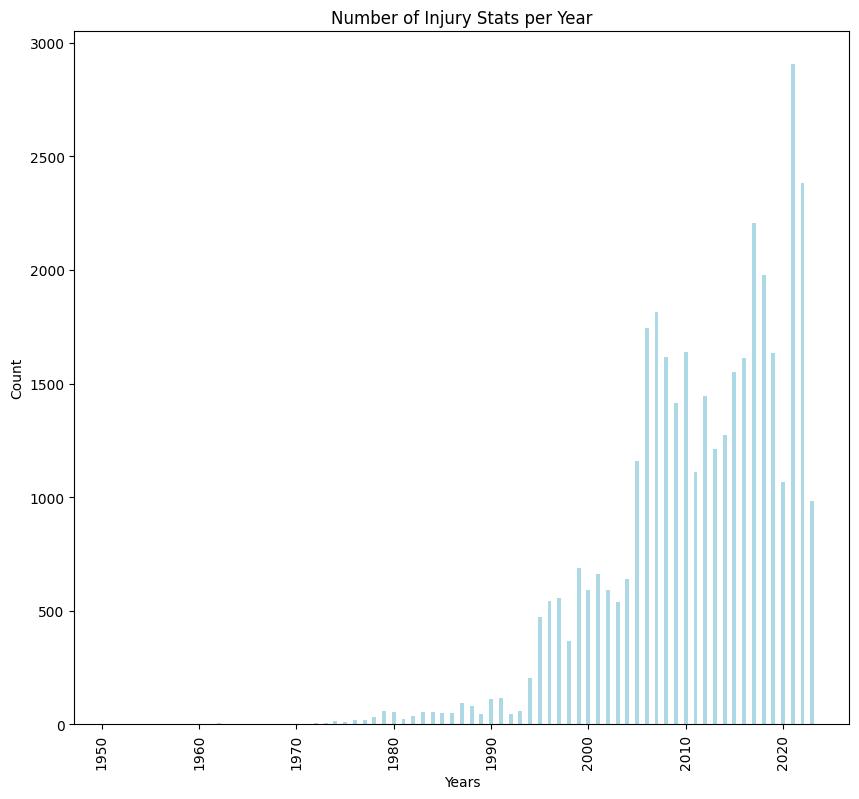

In [172]:
injuries['year'] = injuries['date'].dt.year

years = []
year_counts = []

for year in injuries['year'].unique():
  num = injuries[injuries['year'] == year].shape[0]
  years.append(year)
  year_counts.append(num)

print(injuries['year'].unique())

plt.figure(figsize=(10, 9))
plt.title("Number of Injury Stats per Year")

bar = plt.bar(years, year_counts, color='lightblue', width = 0.4)

plt.xlabel("Years")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# temp to find sample sets



# ---------------------

# filtered_df = injuries[injuries['team'] == 'Bullets']
# sample = filtered_df.sample(n=1)
# print(sample)

Adding 'player' attribute that indicates which player was acquired or relinquished.

In [173]:
injuries['player'] = injuries['relinquished']
injuries['player'] = injuries['player'].fillna(injuries['acquired'])
print(injuries['player'].isna().sum())
injuries = injuries.dropna(subset=['player'])
print(injuries['player'].isna().sum())
injuries.head()

1
0


,date,team,acquired,relinquished,notes,year,player
0,1951-12-25,Bullets,NaN,Don Barksdale,placed on IL,1951,Don Barksdale
1,1952-12-26,Knicks,NaN,Max Zaslofsky,placed on IL with torn side muscle,1952,Max Zaslofsky
2,1956-12-29,Knicks,NaN,Jim Baechtold,placed on inactive list,1956,Jim Baechtold
3,1959-01-16,Lakers,NaN,Elgin Baylor,player refused to play after being denied a ro...,1959,Elgin Baylor
4,1961-11-26,Lakers,NaN,Elgin Baylor,player reported for military duty,1961,Elgin Baylor


Adding team abbreviation column (active team abbreviations)

In [174]:
print(injuries['team'].unique())
print(injuries['team'].nunique())

teams_list = ['Bullets', 'Knicks', 'Lakers', 'Zephyrs', 'Pistons', 'Bucks', 'Colonels (ABA)',
       'Squires (ABA)', 'Chaparrals (ABA)', 'Cavaliers', 'Tams (ABA)', 'Kings',
       'Bulls', 'Rockets', 'Nets (ABA)', 'Spirits (ABA)', 'Hawks', 'Stars (ABA)',
       'Celtics', 'Braves', '76ers', 'Jazz', 'Nuggets (ABA)', 'Sonics', 'Warriors',
       'Suns', 'Nets', 'Spurs', 'Blazers', 'Clippers', 'Cavailers', 'Nuggets', 'Pacers',
       'Mavericks', 'Hornets', 'Heat', 'Timberwolves', 'Magic', 'Raptors', 'Grizzlies',
       'Wizards', 'Bobcats', 'Thunder', 'Pelicans']

team_map = {'Bullets': 'WAS', 'Knicks': 'NYK', 'Lakers': 'LAL', 'Zephyrs': 'WAS',
            'Pistons': 'DET', 'Bucks': 'MIL', 'Colonels (ABA)': None, 'Squires (ABA)': None,
            'Chaparrals (ABA)': 'SAS', 'Cavaliers': 'CLE', 'Tams (ABA)': None, 'Kings': 'SAC',
            'Bulls': 'CHI', 'Rockets': 'HOU', 'Nets (ABA)': 'BKN', 'Spirits (ABA)': None,
            'Hawks': 'ATL', 'Stars (ABA)': None, 'Celtics': 'BOS', 'Braves': 'LAC',
            '76ers': 'PHI', 'Jazz': 'UTH', 'Nuggets (ABA)': 'DEN', 'Sonics': 'OKC',
            'Warriors': 'GSW', 'Suns': 'PHX', 'Nets': 'BKN', 'Spurs': 'SAS', 'Blazers': 'POR',
            'Clippers': 'LAC', 'Cavailers': 'CLE', 'Nuggets': 'DEN', 'Pacers': 'IND',
            'Mavericks': 'DAL', 'Hornets': 'CHH', 'Heat': 'MIA', 'Timberwolves': 'MIN',
            'Magic': 'ORL', 'Raptors': 'TOR', 'Grizzlies': 'MEM', 'Wizards': 'WAS',
            'Bobcats': 'CHH', 'Thunder': 'OKC', 'Pelicans': 'NOP'}

injuries['team_abbreviation'] = injuries['team'].replace(team_map)
print(injuries['team_abbreviation'].nunique())
injuries.head()

['Bullets' 'Knicks' 'Lakers' 'Zephyrs' 'Pistons' 'Bucks' 'Colonels (ABA)'
 'Squires (ABA)' 'Chaparrals (ABA)' 'Cavaliers' 'Tams (ABA)' 'Kings'
 'Bulls' 'Rockets' 'Nets (ABA)' 'Spirits (ABA)' 'Hawks' 'Stars (ABA)'
 'Celtics' 'Braves' '76ers' 'Jazz' 'Nuggets (ABA)' 'Sonics' 'Warriors'
 'Suns' 'Nets' 'Spurs' 'Blazers' 'Clippers' 'Cavailers' 'Nuggets' 'Pacers'
 'Mavericks' 'Hornets' 'Heat' 'Timberwolves' 'Magic' 'Raptors' 'Grizzlies'
 'Wizards' 'Bobcats' 'Thunder' 'Pelicans']
44
30


,date,team,acquired,relinquished,notes,year,player,team_abbreviation
0,1951-12-25,Bullets,NaN,Don Barksdale,placed on IL,1951,Don Barksdale,WAS
1,1952-12-26,Knicks,NaN,Max Zaslofsky,placed on IL with torn side muscle,1952,Max Zaslofsky,NYK
2,1956-12-29,Knicks,NaN,Jim Baechtold,placed on inactive list,1956,Jim Baechtold,NYK
3,1959-01-16,Lakers,NaN,Elgin Baylor,player refused to play after being denied a ro...,1959,Elgin Baylor,LAL
4,1961-11-26,Lakers,NaN,Elgin Baylor,player reported for military duty,1961,Elgin Baylor,LAL


Remove datapoints where abbreviation is None

In [175]:
nan = injuries[injuries[['team_abbreviation']].isna().any(axis=1)].shape[0]
print(nan)

injuries = injuries.dropna(subset=['team_abbreviation'])

12


Add injury start date, injury end date features.

In [176]:
# Data cleaning: remove datapoints where player name is not a name
def contains_terms(alist):
  return 'IL' in alist or '(DTD)' in alist

injuries['bad_name'] = False
injuries['bad_name'] = injuries['player'].str.split(' ').apply(contains_terms)

injuries = injuries[injuries['bad_name'] == False]
injuries = injuries.drop(['bad_name'], axis=1)

In [177]:
players = injuries['player'].unique()

# temp count for print testing
count = 0

# injuries['injury_event'] = None
# injuries['start_date'] = pd.NaT
# injuries['end_date'] = pd.NaT
# injuries['injury_days'] = None

new_injuries = pd.DataFrame(columns=injuries.columns)
new_injuries['injury_event'] = None
new_injuries['start_date'] = pd.NaT
new_injuries['end_date'] = pd.NaT
new_injuries['injury_days'] = None
new_injuries['long_term'] = None


for player in players:
  # player_injuries contains every injury event player inovled in, sorted by date
  player_injuries = injuries[injuries["player"] == player].sort_values(by='date')

  player_injuries['injury_event'] = np.where(player_injuries['acquired'].isna(), 'relinquished', 'acquired')

  # start_date = date if placed on IL, end_date = date if back from IL
  player_injuries.loc[player_injuries['injury_event'] == 'relinquished', 'start_date'] = player_injuries['date']
  player_injuries.loc[player_injuries['injury_event'] == 'acquired', 'end_date'] = player_injuries['date']

  # add prev_date, prev_injury, prev_notes
  player_injuries['prev_date'] = player_injuries['date'].shift(1)
  player_injuries['prev_event'] = player_injuries['injury_event'].shift(1)
  player_injuries['prev_notes'] = player_injuries['notes'].shift(1)

  # Fill start date based on previous entry
  player_injuries.loc[player_injuries['start_date'].isna(), 'start_date'] = player_injuries['prev_date']
  player_injuries.loc[player_injuries['prev_event'] == player_injuries['injury_event'], 'start_date'] = player_injuries['end_date'] - pd.Timedelta(days=2)
  player_injuries.loc[player_injuries['end_date'] - player_injuries['start_date'] >= pd.Timedelta(days=330), 'start_date'] = player_injuries['end_date'] - pd.Timedelta(days=2)

  # update notes with previous entry to save info
  player_injuries.loc[player_injuries['notes'].str.strip() == 'activated from IL', 'notes'] = player_injuries['prev_notes']

  # check if injury long or short term:
  def check_long_term(notes):
    if notes == None:
      return False
    inj_words = ["surgery", "operation", "arthroscopic", "repair", "surgical", "procedure",
                 "acl", "mcl", "achilles", "ruptured", "torn ligament", "fracture", "herniated",
                 "spine", "vertebrae", "chronic", "degenerative", "serious", "severe",
                 "prolonged", "out for season", "season-ending", "indefinitely", "neuropathy",
                 "stress fracture", "torn achilles", "rehabilitation", "recovery from surgery",
                  "fractured", "torn", "tear"]
    notes = notes.lower()
    for word in inj_words:
      if word in notes:
        return True
    return False

  player_injuries['long_term'] = False
  player_injuries.loc[player_injuries['end_date'] - player_injuries['start_date'] >= pd.Timedelta(days=30), 'long_term'] = player_injuries['notes'].apply(check_long_term)

  # if true, leave as is. If false, limit the amount of time.
  player_injuries.loc[(player_injuries['long_term'] == False) & (player_injuries['end_date'] - player_injuries['start_date'] >= pd.Timedelta(days=30)), 'start_date'] = player_injuries['end_date'] - pd.Timedelta(days=2)

  # if player_injuries has odd number of entries, fill last nan entry with end_date as one day later than start
  if player_injuries.shape[0] % 2 != 0:
    if pd.isna(player_injuries.iloc[-1]['end_date']):
      player_injuries.loc[player_injuries.index[-1], 'end_date'] = player_injuries['start_date'].iloc[-1] + pd.Timedelta(days=2)
    elif pd.isna(player_injuries.iloc[-1]['start_date']):
      player_injuries.loc[player_injuries.index[-1], 'start_date'] = player_injuries['end_date'].iloc[-1] - pd.Timedelta(days=2)

  # player_injuries = player_injuries.dropna(subset=['prev_date'])
  player_injuries = player_injuries.dropna(subset=['start_date', 'end_date'])
  player_injuries = player_injuries.drop(['prev_date', 'prev_notes', 'prev_event'], axis=1)

  count += 1
  print("\rPlayer " + str(count) + "/" + str(len(players)), end='')

  # # For testing:
  # # if count % 750 == 0:
  # if count % 500 == 0:
  #   print("\ntest (size = " + str(player_injuries.shape[0]) + "): ")
  #   print(player_injuries.shape[0])
  #   print(player_injuries.head(10))

  # if str(player).strip() == 'Andre Roberson':
  # # if str(player).strip() == 'Roger Powell':
  #   print(player_injuries.head(30))
  #   # break

  new_injuries = pd.concat([new_injuries, player_injuries], ignore_index=True)

new_injuries['date_diff'] = new_injuries['end_date'] - new_injuries['start_date']

Player 31/2782

/var/folders/jm/7yj3tnf94x10z9lykp2pcp8r0000gn/T/ipykernel_50300/1050340063.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_injuries = pd.concat([new_injuries, player_injuries], ignore_index=True)


Player 2782/2782

In [178]:
new_injuries.drop(['acquired', 'relinquished', 'long_term'], axis=1, inplace=True)

In [179]:
print(new_injuries.shape)
new_injuries.head(10)

(18035, 11)


,date,team,notes,year,player,team_abbreviation,injury_event,start_date,end_date,injury_days,date_diff
0,1951-12-25,Bullets,placed on IL,1951,Don Barksdale,WAS,relinquished,1951-12-25,1951-12-27,NaN,2 days
1,1952-12-26,Knicks,placed on IL with torn side muscle,1952,Max Zaslofsky,NYK,relinquished,1952-12-26,1952-12-28,NaN,2 days
2,1956-12-29,Knicks,placed on inactive list,1956,Jim Baechtold,NYK,relinquished,1956-12-29,1956-12-31,NaN,2 days
3,1962-03-24,Lakers,player given 2-day pass from military duty,1962,Elgin Baylor,LAL,acquired,1962-03-22,1962-03-24,NaN,2 days
4,1962-03-31,Lakers,player given weekend pass from military duty,1962,Elgin Baylor,LAL,acquired,1962-03-29,1962-03-31,NaN,2 days
5,1962-11-06,Zephyrs,activated from disabled list,1962,Al Ferrari,WAS,acquired,1962-10-25,1962-11-06,NaN,12 days
6,1962-11-14,Zephyrs,placed on disabled list with knee injury,1962,Al Ferrari,WAS,relinquished,1962-11-14,1962-11-16,NaN,2 days
7,1965-09-11,Pistons,service in army (date approximate),1965,Terry Dischinger,DET,relinquished,1965-09-11,1965-09-13,NaN,2 days
8,1969-10-28,Bucks,placed on IL with sprained ankle,1969,Bob Greacen,MIL,acquired,1969-10-15,1969-10-28,NaN,13 days
9,1969-12-03,Bucks,deployed to National Guard for remainder of th...,1969,John Arthurs,MIL,relinquished,1969-12-03,1969-12-05,NaN,2 days


Test top time ranges

In [ ]:
# # Sort the differences in descending order
# sorted_df = new_injuries.sort_values(by='date_diff', ascending=False)

# # Get the top rows with the largest differences
# top_rows = sorted_df.head(100)

# # Print the largest, second largest, and third largest differences along with the 'a' entries
# for idx, row in top_rows.iterrows():
#     print(f"Date Difference: {row['date_diff']} days, Entry: {row['player']}, Notes: {row['notes']}")

# # injuries.drop(['date_diff'], axis=1, inplace=True)

In [180]:
# Add column for date range
def create_interval(row):
  return pd.Interval(left=row['start_date'], right=row['end_date'], closed='both')

new_injuries['date_range'] = new_injuries.apply(create_interval, axis=1)

### Rankings Dataset

### Games Dataset

In [181]:
print(games['wl_home'].unique())
print(games['wl_home'].isna().sum())
print(games[games['wl_home'].isna() == True])

['L' 'W' nan]
2
       season_id  team_id_home team_abbreviation_home  team_name_home  \
46430      12007    1610612738                    BOS  Boston Celtics   
47823      12008    1610612756                    PHX    Phoenix Suns   

        game_id            game_date matchup_home wl_home  min  fgm_home  \
46430  10700072  2007-10-19 00:00:00  BOS vs. NJN     NaN  120      12.0   
47823  10800035  2008-10-11 00:00:00  PHX vs. DEN     NaN  240      25.0   

       fga_home  fg_pct_home  fg3m_home  fg3a_home  fg3_pct_home  ftm_home  \
46430      29.0        0.414        3.0        8.0         0.375       9.0   
47823      79.0        0.316        2.0       16.0         0.125      20.0   

       fta_home  ft_pct_home  oreb_home  dreb_home  reb_home  ast_home  \
46430      12.0         0.75        3.0       15.0      18.0       8.0   
47823      29.0         0.69       22.0       30.0      52.0       8.0   

       stl_home  blk_home  tov_home  pf_home  pts_home  plus_minus_home  \
46

Alternatively, convert team names that have been changed to what they are now. (Also remove any teams that no longer exist?)

In [182]:
team_abv_map = {
    'TCB': 'ATL',
    'MIH': 'ATL',
    'STL': 'ATL',
    'NJN': 'BKN',
    'CHA': 'CHH',
    'FTW': 'DET',
    'PHW': 'GSW',
    'SFW': 'GSW',
    'GOS': 'GSW',
    'SDR': 'HOU',
    'BUF': 'LAC',
    'SDC': 'LAC',
    'MNL': 'LAL',
    'VAN': 'MEM',
    'NOH': 'NOP',
    'CHH': 'NOP',
    'NOK': 'NOP',
    'SEA': 'OKC',
    'SYR': 'PHI',
    'PHL': 'PHI',
    'ROC': 'SAC',
    'CIN': 'SAC',
    'KCK': 'SAC',
    'NOJ': 'UTH',
    'UTA': 'UTH',
    'CHZ': 'WAS',
    'BLT': 'WAS',
    'CAP':'WAS',
    'SAN': 'SAS',
    'DN': 'DEN'
    }

games['team_abbreviation_home'] = games['team_abbreviation_home'].replace(team_abv_map)
games['team_abbreviation_away'] = games['team_abbreviation_away'].replace(team_abv_map)
print(games['team_abbreviation_home'].unique())
print(len(games['team_abbreviation_home'].unique()))

teams_list = ['ATL', 'BOS', 'CHH', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'BKN', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'TOR', 'UTH', 'WAS', 'SAS']
games = games[games['team_abbreviation_home'].isin(teams_list)]
games = games[games['team_abbreviation_away'].isin(teams_list)]
print(games['team_abbreviation_home'].unique())
print(len(games['team_abbreviation_home'].unique()))

['HUS' 'BOM' 'PRO' 'CHS' 'DEF' 'CLR' 'PIT' 'BOS' 'GSW' 'NYK' 'WAS' 'BAL'
 'JET' 'DET' 'SAC' 'LAL' 'ATL' 'INO' 'WAT' 'AND' 'SHE' 'PHI' 'DEN' 'EST'
 'WST' 'CHI' 'HOU' 'OKC' 'MIL' 'PHX' 'LAC' 'POR' 'CLE' 'UTH' 'SAS' 'IND'
 'BKN' 'DAL' 'NOP' 'MIA' 'ORL' 'MIN' 'TOR' 'MEM' 'CHH' 'LYV' 'BAR' 'ROM'
 'KHI' 'MTA' 'EPT' 'LRO' 'MAL' 'MMT' 'RMA' 'CHN' 'MLN' 'FBU' 'ALB' 'EAM'
 'FCB' 'UBB' 'RMD' 'FLA' 'STP' 'GNS' 'DRT' 'LBN']
68
['GSW' 'NYK' 'BOS' 'WAS' 'DET' 'SAC' 'LAL' 'ATL' 'PHI' 'DEN' 'CHI' 'HOU'
 'OKC' 'MIL' 'PHX' 'LAC' 'POR' 'CLE' 'UTH' 'SAS' 'IND' 'BKN' 'DAL' 'NOP'
 'MIA' 'ORL' 'MIN' 'TOR' 'MEM' 'CHH']
30


**Bar Chart:** Calculate and visualize how many NaN values are in other game statistics to determine the feasibility of engineering summary statistics.

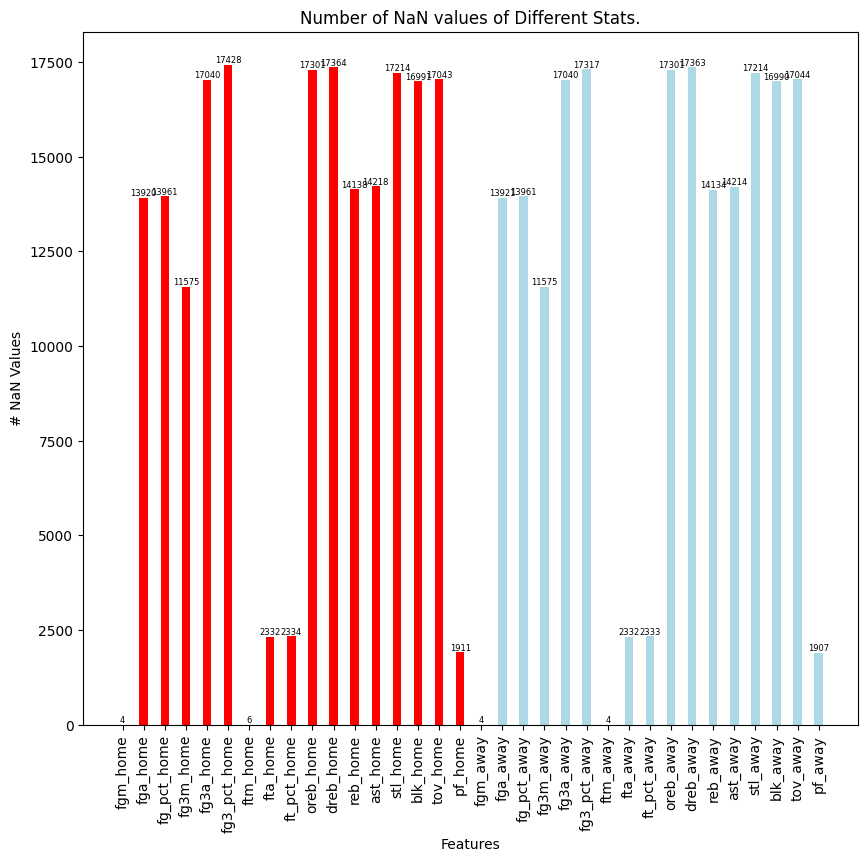

In [183]:
# Home Stats
nan_fgm_home = games['fgm_home'].isna().sum()
nan_fga_home = games['fga_home'].isna().sum()
nan_fg_pct_home = games['fg_pct_home'].isna().sum()
nan_fg3m_home = games['fg3m_home'].isna().sum()
nan_fg3a_home = games['fg3a_home'].isna().sum()
nan_fg3_pct_home = games['fg3_pct_home'].isna().sum()
nan_ftm_home = games['ftm_home'].isna().sum()
nan_fta_home = games['fta_home'].isna().sum()
nan_ft_pct_home = games['ft_pct_home'].isna().sum()
nan_oreb_home = games['oreb_home'].isna().sum()
nan_dreb_home = games['dreb_home'].isna().sum()
nan_reb_home = games['reb_home'].isna().sum()
nan_ast_home = games['ast_home'].isna().sum()
nan_stl_home = games['stl_home'].isna().sum()
nan_blk_home = games['blk_home'].isna().sum()
nan_tov_home = games['tov_home'].isna().sum()
nan_pf_home = games['pf_home'].isna().sum()

# Away Stats
nan_fgm_away = games['fgm_away'].isna().sum()
nan_fga_away = games['fga_away'].isna().sum()
nan_fg_pct_away = games['fg_pct_away'].isna().sum()
nan_fg3m_away = games['fg3m_away'].isna().sum()
nan_fg3a_away = games['fg3a_away'].isna().sum()
nan_fg3_pct_away = games['fg3_pct_away'].isna().sum()
nan_ftm_away = games['ftm_away'].isna().sum()
nan_fta_away = games['fta_away'].isna().sum()
nan_ft_pct_away = games['ft_pct_away'].isna().sum()
nan_oreb_away = games['oreb_away'].isna().sum()
nan_dreb_away = games['dreb_away'].isna().sum()
nan_reb_away = games['reb_away'].isna().sum()
nan_ast_away = games['ast_away'].isna().sum()
nan_stl_away = games['stl_away'].isna().sum()
nan_blk_away = games['blk_away'].isna().sum()
nan_tov_away = games['tov_away'].isna().sum()
nan_pf_away = games['pf_away'].isna().sum()

bar_labels_home = ['fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home',
              'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home',
              'dreb_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home',
              'tov_home', 'pf_home']
bar_labels_away = ['fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
              'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
              'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away',
              'tov_away', 'pf_away']
bar_labels = bar_labels_home + bar_labels_away

feats_home = [nan_fgm_home, nan_fga_home, nan_fg_pct_home, nan_fg3m_home,
              nan_fg3a_home, nan_fg3_pct_home, nan_ftm_home, nan_fta_home,
              nan_ft_pct_home, nan_oreb_home, nan_dreb_home, nan_reb_home,
              nan_ast_home, nan_stl_home, nan_blk_home, nan_tov_home, nan_pf_home]
feats_away = [nan_fgm_away, nan_fga_away, nan_fg_pct_away, nan_fg3m_away,
              nan_fg3a_away, nan_fg3_pct_away, nan_ftm_away, nan_fta_away,
              nan_ft_pct_away, nan_oreb_away, nan_dreb_away, nan_reb_away,
              nan_ast_away, nan_stl_away, nan_blk_away, nan_tov_away, nan_pf_away]
feats = feats_home + feats_away

colors_home = ['red'] * 17
colors_away = ['lightblue'] * 17
colors = colors_home + colors_away

plt.figure(figsize=(10, 9))
plt.title("Number of NaN values of Different Stats.")

bar = plt.bar(bar_labels, feats, color=colors, width = 0.4)

plt.xlabel("Features")
plt.ylabel("# NaN Values")
plt.bar_label(bar, fontsize=6)
plt.xticks(rotation=90)
plt.show()

**Feature Encoding:** Use label encoder for wl_home, wl_away so they can be summed.

In [184]:
label_encoder = preprocessing.LabelEncoder()

# wl_home and wl_away W=1, L=0
games['wl_home']= label_encoder.fit_transform(games['wl_home'])
games['wl_away']= label_encoder.fit_transform(games['wl_away'])


**Feature Engineering:** Create new features to summarize team statistics over previous games, as opposed to current game statistics. Create features to represent *(1) average points scored in last 5 and 10 games, (2) sum of wins in past 5 and 10 games, (3) whether or not team played back-to-back, (4) the number of games won in a row, and (5) the number of rest days between current and previous game* for home and away teams in each datapoint.

In [185]:
games['game_date'] = pd.to_datetime(games['game_date'])

# stats to add: home_last_5, away_last_5,
games['home_last_5'] = np.nan
games['away_last_5'] = np.nan
games['home_last_10'] = np.nan
games['away_last_10'] = np.nan

games['home_wins_5'] = np.nan
games['away_wins_5'] = np.nan
games['home_wins_10'] = np.nan
games['away_wins_10'] = np.nan

games['home_back_to_back'] = np.nan
games['away_back_to_back'] = np.nan

games['home_win_streak'] = np.nan
games['away_win_streak'] = np.nan

games['home_rest_days'] = np.nan
games['away_rest_days'] = np.nan

teams = games['team_abbreviation_home'].unique()

count = 0

# sample_id = None
# sample_found = False

for team in teams:
  # team_games contains every game team played in, sorted by date
  team_games = games[(games["team_abbreviation_home"] == team) | (games["team_abbreviation_away"] == team)].sort_values(by='game_date')

  # fill home_last_5, away_last_5 in team_games with avg of past 5 pts
  team_games['team_pts'] = team_games[team_games["team_abbreviation_home"] == team]['pts_home']
  team_games['team_pts'] = team_games['team_pts'].fillna(team_games[team_games["team_abbreviation_away"] == team]['pts_away'])

  team_games['avg_pts'] = team_games['team_pts'].shift(1).rolling(window=5).mean()

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_last_5'] = team_games['avg_pts']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_last_5'] = team_games['avg_pts']
  team_games.drop(['team_pts', 'avg_pts'], axis=1, inplace=True)

  # find last 10 games avg pts
  team_games['team_pts'] = team_games[team_games["team_abbreviation_home"] == team]['pts_home']
  team_games['team_pts'] = team_games['team_pts'].fillna(team_games[team_games["team_abbreviation_away"] == team]['pts_away'])

  team_games['avg_pts'] = team_games['team_pts'].shift(1).rolling(window=10).mean()

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_last_10'] = team_games['avg_pts']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_last_10'] = team_games['avg_pts']
  team_games.drop(['team_pts', 'avg_pts'], axis=1, inplace=True)

  # find last 5 wins sum
  team_games['team_wins'] = team_games[team_games["team_abbreviation_home"] == team]['wl_home']
  team_games['team_wins'] = team_games['team_wins'].fillna(team_games[team_games["team_abbreviation_away"] == team]['wl_away'])

  team_games['wins_sum'] = team_games['team_wins'].shift(1).rolling(window=5).sum()

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_wins_5'] = team_games['wins_sum']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_wins_5'] = team_games['wins_sum']
  team_games.drop(['team_wins', 'wins_sum'], axis=1, inplace=True)

  # find last 10 wins sum
  team_games['team_wins'] = team_games[team_games["team_abbreviation_home"] == team]['wl_home']
  team_games['team_wins'] = team_games['team_wins'].fillna(team_games[team_games["team_abbreviation_away"] == team]['wl_away'])

  team_games['wins_sum'] = team_games['team_wins'].shift(1).rolling(window=10).sum()

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_wins_10'] = team_games['wins_sum']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_wins_10'] = team_games['wins_sum']
  team_games.drop(['team_wins', 'wins_sum'], axis=1, inplace=True)

  # find back-to-back games (if previous game was the day before)
  team_games['team_previous_date'] = team_games['game_date'].shift(1)

  team_games['back_to_back'] = np.where(team_games['game_date'] == (team_games['team_previous_date'] + pd.Timedelta(days=1)), 1, 0)

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_back_to_back'] = team_games['back_to_back']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_back_to_back'] = team_games['back_to_back']
  team_games.drop(['team_previous_date', 'back_to_back'], axis=1, inplace=True)

  # (Maybe) win/loss streaks (how many games in a row won/lost before current game) (only up to 10)
  def find_streak(window):
    sum = 0
    for item in window.iloc[::-1]:
      if item == 1:
        sum += 1
      else:
        return sum
    return sum

  team_games['team_wins'] = team_games[team_games["team_abbreviation_home"] == team]['wl_home']
  team_games['team_wins'] = team_games['team_wins'].fillna(team_games[team_games["team_abbreviation_away"] == team]['wl_away'])

  team_games['wins_sum'] = team_games['team_wins'].shift(1).rolling(window=10).apply(find_streak)

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_win_streak'] = team_games['wins_sum']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_win_streak'] = team_games['wins_sum']
  team_games.drop(['team_wins', 'wins_sum'], axis=1, inplace=True)

  # Number of rest days leading up to game
  team_games['team_previous_date'] = team_games['game_date'].shift(1)

  team_games['rest_days'] = team_games['game_date'] - team_games['team_previous_date']
  team_games['rest_days'] = team_games['rest_days'].dt.days

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_rest_days'] = team_games['rest_days']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_rest_days'] = team_games['rest_days']
  team_games.drop(['team_previous_date', 'rest_days'], axis=1, inplace=True)

  # (Maybe) seasonal averages for points/wins


  # update games.loc with new features.
  games = games.combine_first(team_games)

  count += 1
  print("\rTeam " + str(count) + "/" + str(len(teams)), end='')

  # FOR TESTING (sample 10 consecutive points)
  #  # print(team_games.sample(n=1))
  # start_idx = np.random.randint(0, len(team_games) - 10 + 1)
  # consecutive_sample = team_games.iloc[start_idx:start_idx + 10]
  # print(consecutive_sample[['team_abbreviation_home', 'team_abbreviation_away', 'game_date', 'home_matchup_wins', 'away_matchup_wins']])
  # break

print(games.shape)
games.head()


Team 30/30(63881, 69)


,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type,home_last_5,away_last_5,home_last_10,away_last_10,home_wins_5,away_wins_5,home_wins_10,away_wins_10,home_back_to_back,away_back_to_back,home_win_streak,away_win_streak,home_rest_days,away_rest_days
23,21946,1610612744,GSW,Philadelphia Warriors,24600023,1946-11-14,PHW vs. WAS,1,0,26.0,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,68.0,3,0,1610610036,WAS,Washington Capitols,WAS @ PHW,0,25.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,65.0,-3,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
51,21946,1610612744,GSW,Philadelphia Warriors,24600052,1946-11-26,PHW vs. BOS,1,0,26.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,12,0,1610612738,BOS,Boston Celtics,BOS @ PHW,0,20.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,-12,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,12.0,NaN
62,21946,1610612752,NYK,New York Knicks,24600063,1946-11-30,NYK vs. PHW,1,0,26.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,4,0,1610612744,GSW,Philadelphia Warriors,PHW @ NYK,0,22.0,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,-4,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,4.0
75,21946,1610612744,GSW,Philadelphia Warriors,24600076,1946-12-05,PHW vs. NYK,1,0,22.0,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,11,0,1610612752,NYK,New York Knicks,NYK @ PHW,0,21.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,-11,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,5.0,5.0
79,21946,1610612738,BOS,Boston Celtics,24600078,1946-12-07,BOS vs. NYK,0,0,25.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,-25,0,1610612752,NYK,New York Knicks,NYK @ BOS,1,38.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,25,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,11.0,2.0


**Feature Engineering:** Add features representing the wins of either team in their previous 3, 6, and 9 matchups.

In [186]:
# games['home_matchup_wins'] = np.nan
# games['away_matchup_wins'] = np.nan
games['home_matchup_wins_3'] = np.nan
games['away_matchup_wins_3'] = np.nan
games['home_matchup_wins_6'] = np.nan
games['away_matchup_wins_6'] = np.nan
games['home_matchup_wins_10'] = np.nan
games['away_matchup_wins_10'] = np.nan

count = 0

# Trying to separate matchups stuff from the rest
for team in teams:
    # team_games contains every game team played in, sorted by date
    team_games = games[(games["team_abbreviation_home"] == team) | (games["team_abbreviation_away"] == team)].sort_values(by='game_date')

    # last 3,6,10 matchup outcomes between the teams
    def matchup_wins(row):
        op = None
        if row['team_abbreviation_home'] == team:
            op = row['team_abbreviation_away']
        else:
            op = row['team_abbreviation_home']

        matchups = team_games[((team_games["team_abbreviation_home"] == team) & (team_games["team_abbreviation_away"] == op)) | ((team_games["team_abbreviation_home"] == op) & (team_games["team_abbreviation_away"] == team))].sort_values(by='game_date')

        matchups = matchups[matchups['game_date'] < row['game_date']]

        matchups['team_wins'] = matchups[matchups["team_abbreviation_home"] == team]['wl_home']
        matchups['team_wins'] = matchups['team_wins'].fillna(matchups[matchups["team_abbreviation_away"] == team]['wl_away'])
        
        return (matchups['team_wins'].tail(3).sum(), matchups['team_wins'].tail(6).sum(), matchups['team_wins'].tail(10).sum())
    
    team_games[['matchup_wins_3', 'matchup_wins_6', 'matchup_wins_10']] = team_games.apply(matchup_wins, axis=1, result_type='expand')

    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_matchup_wins_3'] = team_games['matchup_wins_3']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_matchup_wins_3'] = team_games['matchup_wins_3']
    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_matchup_wins_6'] = team_games['matchup_wins_6']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_matchup_wins_6'] = team_games['matchup_wins_6']
    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_matchup_wins_10'] = team_games['matchup_wins_10']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_matchup_wins_10'] = team_games['matchup_wins_10']
    team_games.drop(['matchup_wins_3', 'matchup_wins_6', 'matchup_wins_10'], axis=1, inplace=True)

    games = games.combine_first(team_games)

    count += 1
    print("\rTeam " + str(count) + "/" + str(len(teams)), end='')

print(games.shape)
games.head()    

Team 30/30(63881, 75)


,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type,home_last_5,away_last_5,home_last_10,away_last_10,home_wins_5,away_wins_5,home_wins_10,away_wins_10,home_back_to_back,away_back_to_back,home_win_streak,away_win_streak,home_rest_days,away_rest_days,home_matchup_wins_3,away_matchup_wins_3,home_matchup_wins_6,away_matchup_wins_6,home_matchup_wins_10,away_matchup_wins_10
23,21946,1610612744,GSW,Philadelphia Warriors,24600023,1946-11-14,PHW vs. WAS,1,0,26.0,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,68.0,3,0,1610610036,WAS,Washington Capitols,WAS @ PHW,0,25.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,65.0,-3,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
51,21946,1610612744,GSW,Philadelphia Warriors,24600052,1946-11-26,PHW vs. BOS,1,0,26.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,12,0,1610612738,BOS,Boston Celtics,BOS @ PHW,0,20.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,-12,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,12.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
62,21946,1610612752,NYK,New York Knicks,24600063,1946-11-30,NYK vs. PHW,1,0,26.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,4,0,1610612744,GSW,Philadelphia Warriors,PHW @ NYK,0,22.0,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,-4,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0
75,21946,1610612744,GSW,Philadelphia Warriors,24600076,1946-12-05,PHW vs. NYK,1,0,22.0,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,11,0,1610612752,NYK,New York Knicks,NYK @ PHW,0,21.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,-11,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,5.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0
79,21946,1610612738,BOS,Boston Celtics,24600078,1946-12-07,BOS vs. NYK,0,0,25.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,-25,0,1610612752,NYK,New York Knicks,NYK @ BOS,1,38.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,25,0,Regular Season,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,11.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


**Feature Engineering:** Add features representing the cumulative seasonal averages of different statistics like wins and points.

***IMPORTANT: Future plan: create a value to represent entire seasons counting pre/regular/post season***

In [187]:
games['home_seasonal_win_pct'] = np.nan
games['away_seasonal_win_pct'] = np.nan

count = 0

for team in teams:
    # team_games contains every game team played in, sorted by date
    team_games = games[(games["team_abbreviation_home"] == team) | (games["team_abbreviation_away"] == team)].sort_values(by='game_date')

    # add cumulative mean of wins (w/l) throughout each season
    team_games['team_wins'] = team_games[team_games["team_abbreviation_home"] == team]['wl_home']
    team_games['team_wins'] = team_games['team_wins'].fillna(team_games[team_games["team_abbreviation_away"] == team]['wl_away'])

    team_games['team_seasonal_win_pct'] = team_games.groupby('season_id')['team_wins'].expanding().mean().reset_index(level=0, drop=True).shift(1)
    team_games.loc[team_games.groupby('season_id')['team_wins'].head(1).index, 'team_seasonal_win_pct'] = 0.0

    team_games['team_seasonal_win_pct'] = round(team_games['team_seasonal_win_pct'], 5)

    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_seasonal_win_pct'] = team_games['team_seasonal_win_pct']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_seasonal_win_pct'] = team_games['team_seasonal_win_pct']
    team_games.drop(['team_wins', 'team_seasonal_win_pct'], axis=1, inplace=True)

    # add cumulative mean of pts scored throughout each season
    team_games['team_pts'] = team_games[team_games["team_abbreviation_home"] == team]['pts_home']
    team_games['team_pts'] = team_games['team_pts'].fillna(team_games[team_games["team_abbreviation_away"] == team]['pts_away'])

    team_games['team_seasonal_avg_pts'] = team_games.groupby('season_id')['team_pts'].expanding().mean().reset_index(level=0, drop=True).shift(1)
    team_games.loc[team_games.groupby('season_id')['team_pts'].head(1).index, 'team_seasonal_avg_pts'] = 0.0

    team_games['team_seasonal_avg_pts'] = round(team_games['team_seasonal_avg_pts'], 5)

    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_seasonal_avg_pts'] = team_games['team_seasonal_avg_pts']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_seasonal_avg_pts'] = team_games['team_seasonal_avg_pts']
    team_games.drop(['team_pts', 'team_seasonal_avg_pts'], axis=1, inplace=True)

    games = games.combine_first(team_games)

    count += 1
    print("\rTeam " + str(count) + "/" + str(len(teams)), end='')

print(games.shape)
games.head()

Team 30/30(63881, 79)


,ast_away,ast_home,away_back_to_back,away_last_10,away_last_5,away_matchup_wins_10,away_matchup_wins_3,away_matchup_wins_6,away_rest_days,away_seasonal_avg_pts,away_seasonal_win_pct,away_win_streak,away_wins_10,away_wins_5,blk_away,blk_home,dreb_away,dreb_home,fg3_pct_away,fg3_pct_home,fg3a_away,fg3a_home,fg3m_away,fg3m_home,fg_pct_away,fg_pct_home,fga_away,fga_home,fgm_away,fgm_home,ft_pct_away,ft_pct_home,fta_away,fta_home,ftm_away,ftm_home,game_date,game_id,home_back_to_back,home_last_10,home_last_5,home_matchup_wins_10,home_matchup_wins_3,home_matchup_wins_6,home_rest_days,home_seasonal_avg_pts,home_seasonal_win_pct,home_win_streak,home_wins_10,home_wins_5,matchup_away,matchup_home,min,oreb_away,oreb_home,pf_away,pf_home,plus_minus_away,plus_minus_home,pts_away,pts_home,reb_away,reb_home,season_id,season_type,stl_away,stl_home,team_abbreviation_away,team_abbreviation_home,team_id_away,team_id_home,team_name_away,team_name_home,tov_away,tov_home,video_available_away,video_available_home,wl_away,wl_home
23,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,26.0,NaN,NaN,NaN,NaN,15.0,16.0,1946-11-14,24600023,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.00000,0.00000,NaN,NaN,NaN,WAS @ PHW,PHW vs. WAS,0,NaN,NaN,19.0,21.0,-3,3,65.0,68.0,NaN,NaN,21946,Regular Season,NaN,NaN,WAS,GSW,1610610036,1610612744,Washington Capitols,Philadelphia Warriors,NaN,NaN,0,0,0,1
51,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,26.0,NaN,NaN,NaN,NaN,14.0,14.0,1946-11-26,24600052,0.0,NaN,NaN,0.0,0.0,0.0,12.0,68.00000,1.00000,NaN,NaN,NaN,BOS @ PHW,PHW vs. BOS,0,NaN,NaN,NaN,NaN,-12,12,54.0,66.0,NaN,NaN,21946,Regular Season,NaN,NaN,BOS,GSW,1610612738,1610612744,Boston Celtics,Philadelphia Warriors,NaN,NaN,0,0,0,1
62,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,4.0,67.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,26.0,NaN,NaN,NaN,NaN,16.0,12.0,1946-11-30,24600063,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.00000,0.00000,NaN,NaN,NaN,PHW @ NYK,NYK vs. PHW,0,NaN,NaN,NaN,NaN,-4,4,60.0,64.0,NaN,NaN,21946,Regular Season,NaN,NaN,GSW,NYK,1610612744,1610612752,Philadelphia Warriors,New York Knicks,NaN,NaN,0,0,0,1
75,NaN,NaN,0.0,NaN,NaN,1.0,1.0,1.0,5.0,64.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,22.0,NaN,NaN,NaN,NaN,9.0,18.0,1946-12-05,24600076,0.0,NaN,NaN,0.0,0.0,0.0,5.0,64.66667,0.66667,NaN,NaN,NaN,NYK @ PHW,PHW vs. NYK,0,NaN,NaN,NaN,NaN,-11,11,51.0,62.0,NaN,NaN,21946,Regular Season,NaN,NaN,NYK,GSW,1610612752,1610612744,New York Knicks,Philadelphia Warriors,NaN,NaN,0,0,0,1
79,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,2.0,57.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,25.0,NaN,NaN,NaN,NaN,14.0,15.0,1946-12-07,24600078,0.0,NaN,NaN,0.0,0.0,0.0,11.0,54.00000,0.00000,NaN,NaN,NaN,NYK @ BOS,BOS vs. NYK,0,NaN,NaN,NaN,NaN,25,-25,90.0,65.0,NaN,NaN,21946,Regular Season,NaN,NaN,NYK,BOS,1610612752,1610612738,New York Knicks,Boston Celtics,NaN,NaN,0,0,1,0


**Data Cleaning:** Drop datapoints with NaN for new features.

In [188]:
print(games.shape)

nan = games[games[['home_last_5', 'away_last_5', 'home_last_10', 'away_last_10',
                   'home_wins_5', 'away_wins_5', 'home_wins_10', 'away_wins_10',
                   'home_back_to_back', 'away_back_to_back']].isna().any(axis=1)
                   ].shape[0]
print(nan)

# Later, instead of dropping these values, we can fill them with 0 or avg vals.
games = games.dropna(subset=['home_last_5', 'away_last_5', 'home_last_10',
                             'away_last_10', 'home_wins_5', 'away_wins_5',
                             'home_wins_10', 'away_wins_10', 'home_back_to_back',
                             'away_back_to_back'])
# print(games.sample(n=10))

(63881, 79)
266


In [189]:
# Later just add this to previous cell ^^^
nan = games[games[['home_win_streak', 'away_win_streak', 'home_rest_days',
                   'away_rest_days']].isna().any(axis=1)
                   ].shape[0]
print(nan)

games = games.dropna(subset=['home_win_streak', 'away_win_streak',
                             'home_rest_days', 'away_rest_days'])

0


In [191]:
# Later just add this to previous cell ^^^
nan = games[games[['home_matchup_wins_3', 'away_matchup_wins_3', 'home_matchup_wins_6',
                   'away_matchup_wins_6', 'home_matchup_wins_10', 'away_matchup_wins_10']].isna().any(axis=1)
                   ].shape[0]
print(nan)

0


In [192]:
nan = games[games[['home_seasonal_win_pct', 'away_seasonal_win_pct', 'home_seasonal_avg_pts', 'away_seasonal_avg_pts']].isna().any(axis=1)
                   ].shape[0]
print(nan)

0


**Feature Engineering:**
- *Maybe add distance between cities, but may be implicitly clear from away cities vs home in matchups.*
  - Maybe add city_home, city_away, and this should tell the same info as distance (and account for cities of teams changing over time)
- *Maybe add whether or not a player is injured*
- *Offensive/defensive ratings (efficiencies)*
- *Pregame odds/point spreads for betting*
- *Seasonal Stats*

**Feature Engineering:** Add number of top scorers in that team in that season. Add the avg points of that top scorer. Add whether that scorer is injured per-game. Add whether any secondary players are injured.

Basic Feature Engineering

In [193]:
games['year'] = games['game_date'].dt.year
games['month'] = games['game_date'].dt.month
games['day'] = games['game_date'].dt.day
games['weekday'] = games['game_date'].dt.weekday

Apply injury Information

In [194]:
def check_injured_home(row):
  print("\rIteration " + str(row.name) + ".", end='')

  injuries_team_year = new_injuries[(new_injuries['team_abbreviation'] == row['team_abbreviation_home']) & (new_injuries['year'] == row['year'])]
  for index, row_i in injuries_team_year.iterrows():
    if row['game_date'] in row_i['date_range']:
      return True
  return False

games['injured_player_home'] = games.apply(check_injured_home, axis=1)

Iteration 65695.

In [195]:
def check_injured_away(row):
  print("\rIteration " + str(row.name) + ".", end='')

  injuries_team_year = new_injuries[(new_injuries['team_abbreviation'] == row['team_abbreviation_away']) & (new_injuries['year'] == row['year'])]
  for index, row_i in injuries_team_year.iterrows():
    if row['game_date'] in row_i['date_range']:
      return True
  return False

games['injured_player_away'] = games.apply(check_injured_away, axis=1)

Iteration 65695.

In [196]:
games.head()

,ast_away,ast_home,away_back_to_back,away_last_10,away_last_5,away_matchup_wins_10,away_matchup_wins_3,away_matchup_wins_6,away_rest_days,away_seasonal_avg_pts,away_seasonal_win_pct,away_win_streak,away_wins_10,away_wins_5,blk_away,blk_home,dreb_away,dreb_home,fg3_pct_away,fg3_pct_home,fg3a_away,fg3a_home,fg3m_away,fg3m_home,fg_pct_away,fg_pct_home,fga_away,fga_home,fgm_away,fgm_home,ft_pct_away,ft_pct_home,fta_away,fta_home,ftm_away,ftm_home,game_date,game_id,home_back_to_back,home_last_10,home_last_5,home_matchup_wins_10,home_matchup_wins_3,home_matchup_wins_6,home_rest_days,home_seasonal_avg_pts,home_seasonal_win_pct,home_win_streak,home_wins_10,home_wins_5,matchup_away,matchup_home,min,oreb_away,oreb_home,pf_away,pf_home,plus_minus_away,plus_minus_home,pts_away,pts_home,reb_away,reb_home,season_id,season_type,stl_away,stl_home,team_abbreviation_away,team_abbreviation_home,team_id_away,team_id_home,team_name_away,team_name_home,tov_away,tov_home,video_available_away,video_available_home,wl_away,wl_home,year,month,day,weekday,injured_player_home,injured_player_away
195,NaN,NaN,0.0,60.0,59.6,2.0,2.0,2.0,2.0,60.72727,0.54545,1.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,24.0,NaN,NaN,NaN,NaN,23.0,15.0,1947-02-01,24600197,0.0,59.0,54.8,1.0,1.0,1.0,2.0,59.00000,0.30000,0.0,3.0,0.0,PHW @ NYK,NYK vs. PHW,0,NaN,NaN,NaN,NaN,8,-8,71.0,63.0,NaN,NaN,21946,Regular Season,NaN,NaN,GSW,NYK,1610612744,1610612752,Philadelphia Warriors,New York Knicks,NaN,NaN,0,0,1,0,1947,2,1,5,False,False
202,NaN,NaN,0.0,57.7,53.4,1.0,1.0,1.0,5.0,56.92308,0.38462,0.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,24.0,NaN,NaN,NaN,NaN,11.0,13.0,1947-02-03,24600203,0.0,60.5,62.6,3.0,2.0,3.0,2.0,61.58333,0.58333,2.0,5.0,4.0,BOS @ PHW,PHW vs. BOS,0,NaN,NaN,NaN,NaN,-6,6,55.0,61.0,NaN,NaN,21946,Regular Season,NaN,NaN,BOS,GSW,1610612738,1610612744,Boston Celtics,Philadelphia Warriors,NaN,NaN,0,0,0,1,1947,2,3,0,False,False
209,NaN,NaN,0.0,58.9,55.0,2.0,0.0,2.0,5.0,59.36364,0.27273,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,18.0,NaN,NaN,NaN,NaN,14.0,13.0,1947-02-06,24600211,0.0,55.5,52.8,3.0,3.0,3.0,3.0,56.78571,0.35714,0.0,4.0,1.0,NYK @ BOS,BOS vs. NYK,0,NaN,NaN,NaN,NaN,-1,1,48.0,49.0,NaN,NaN,21946,Regular Season,NaN,NaN,NYK,BOS,1610612752,1610612738,New York Knicks,Boston Celtics,NaN,NaN,0,0,0,1,1947,2,6,3,False,False
221,NaN,NaN,0.0,64.6,61.8,2.0,2.0,2.0,14.0,64.60000,0.80000,3.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,29.0,NaN,NaN,NaN,NaN,18.0,18.0,1947-02-12,24600222,0.0,58.6,52.0,0.0,0.0,0.0,6.0,58.41667,0.25000,0.0,2.0,0.0,WAS @ NYK,NYK vs. WAS,0,NaN,NaN,21.0,17.0,-6,6,72.0,78.0,NaN,NaN,21946,Regular Season,NaN,NaN,WAS,NYK,1610610036,1610612752,Washington Capitols,New York Knicks,NaN,NaN,0,0,0,1,1947,2,12,2,False,False
227,NaN,NaN,0.0,60.6,62.2,1.0,0.0,1.0,12.0,61.53846,0.61538,3.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,27.0,0.615,0.727,26.0,22.0,16.0,16.0,1947-02-15,24600230,0.0,65.3,63.2,3.0,3.0,3.0,3.0,65.27273,0.72727,0.0,8.0,3.0,PHW @ WAS,WAS vs. PHW,0,NaN,NaN,18.0,20.0,-10,10,60.0,70.0,NaN,NaN,21946,Regular Season,NaN,NaN,GSW,WAS,1610612744,1610610036,Philadelphia Warriors,Washington Capitols,NaN,NaN,0,0,0,1,1947,2,15,5,False,False


In [197]:
nan = games[games[['injured_player_home', 'injured_player_away']].isna().any(axis=1)].shape[0]
print(nan)

0


In [198]:
print(games['injured_player_home'].value_counts())

injured_player_home
False    39754
True     23861
Name: count, dtype: int64


Next Steps: Calculate either travel time/distance and direction of travel, number of time zones crossed west/east

Find out average numbers of other stats?

Find out what point in season? Instead of date, include the month or week, the day of the week?

Drop all features that describe current-game stats.

Fill in NaN in wl_home

In [199]:
print(games['wl_home'].unique())
print(games['wl_home'].isna().sum())
# print(games[games['wl_home'] == 2])

games.loc[games['wl_home'] == 2, 'wl_home'] = (games['pts_home'] > games['pts_away']).astype(int)

# print(games[games['game_id'] == 10700072])
# print(games[games['game_id'] == 10800035])

[0 1 2]
0


In [200]:
print(games.columns)

Index(['ast_away', 'ast_home', 'away_back_to_back', 'away_last_10',
       'away_last_5', 'away_matchup_wins_10', 'away_matchup_wins_3',
       'away_matchup_wins_6', 'away_rest_days', 'away_seasonal_avg_pts',
       'away_seasonal_win_pct', 'away_win_streak', 'away_wins_10',
       'away_wins_5', 'blk_away', 'blk_home', 'dreb_away', 'dreb_home',
       'fg3_pct_away', 'fg3_pct_home', 'fg3a_away', 'fg3a_home', 'fg3m_away',
       'fg3m_home', 'fg_pct_away', 'fg_pct_home', 'fga_away', 'fga_home',
       'fgm_away', 'fgm_home', 'ft_pct_away', 'ft_pct_home', 'fta_away',
       'fta_home', 'ftm_away', 'ftm_home', 'game_date', 'game_id',
       'home_back_to_back', 'home_last_10', 'home_last_5',
       'home_matchup_wins_10', 'home_matchup_wins_3', 'home_matchup_wins_6',
       'home_rest_days', 'home_seasonal_avg_pts', 'home_seasonal_win_pct',
       'home_win_streak', 'home_wins_10', 'home_wins_5', 'matchup_away',
       'matchup_home', 'min', 'oreb_away', 'oreb_home', 'pf_away', 'pf_home

In [201]:
games = games.drop(['fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home',
                    'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home',
                    'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home',
                    'blk_home', 'tov_home', 'pf_home', 'pts_home', 'plus_minus_home',
                    'video_available_home'], axis=1)
# potentially add back 'wl_home' to previous drop()

games = games.drop(['wl_away', 'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away',
                    'fg3a_away', 'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away',
                    'oreb_away', 'dreb_away', 'reb_away', 'ast_away', 'stl_away',
                    'blk_away', 'tov_away', 'pf_away', 'pts_away', 'plus_minus_away',
                    'video_available_away'], axis=1)

In [202]:
games = games.drop(['matchup_home', 'matchup_away', 'min', 'team_id_home', 'team_id_away',
                    'team_abbreviation_home', 'team_abbreviation_away', 'game_id'], axis=1)

In [203]:
print(games.columns)
games.head()

Index(['away_back_to_back', 'away_last_10', 'away_last_5',
       'away_matchup_wins_10', 'away_matchup_wins_3', 'away_matchup_wins_6',
       'away_rest_days', 'away_seasonal_avg_pts', 'away_seasonal_win_pct',
       'away_win_streak', 'away_wins_10', 'away_wins_5', 'game_date',
       'home_back_to_back', 'home_last_10', 'home_last_5',
       'home_matchup_wins_10', 'home_matchup_wins_3', 'home_matchup_wins_6',
       'home_rest_days', 'home_seasonal_avg_pts', 'home_seasonal_win_pct',
       'home_win_streak', 'home_wins_10', 'home_wins_5', 'season_id',
       'season_type', 'team_name_away', 'team_name_home', 'wl_home', 'year',
       'month', 'day', 'weekday', 'injured_player_home',
       'injured_player_away'],
      dtype='object')


,away_back_to_back,away_last_10,away_last_5,away_matchup_wins_10,away_matchup_wins_3,away_matchup_wins_6,away_rest_days,away_seasonal_avg_pts,away_seasonal_win_pct,away_win_streak,away_wins_10,away_wins_5,game_date,home_back_to_back,home_last_10,home_last_5,home_matchup_wins_10,home_matchup_wins_3,home_matchup_wins_6,home_rest_days,home_seasonal_avg_pts,home_seasonal_win_pct,home_win_streak,home_wins_10,home_wins_5,season_id,season_type,team_name_away,team_name_home,wl_home,year,month,day,weekday,injured_player_home,injured_player_away
195,0.0,60.0,59.6,2.0,2.0,2.0,2.0,60.72727,0.54545,1.0,5.0,3.0,1947-02-01,0.0,59.0,54.8,1.0,1.0,1.0,2.0,59.00000,0.30000,0.0,3.0,0.0,21946,Regular Season,Philadelphia Warriors,New York Knicks,0,1947,2,1,5,False,False
202,0.0,57.7,53.4,1.0,1.0,1.0,5.0,56.92308,0.38462,0.0,5.0,2.0,1947-02-03,0.0,60.5,62.6,3.0,2.0,3.0,2.0,61.58333,0.58333,2.0,5.0,4.0,21946,Regular Season,Boston Celtics,Philadelphia Warriors,1,1947,2,3,0,False,False
209,0.0,58.9,55.0,2.0,0.0,2.0,5.0,59.36364,0.27273,0.0,2.0,0.0,1947-02-06,0.0,55.5,52.8,3.0,3.0,3.0,3.0,56.78571,0.35714,0.0,4.0,1.0,21946,Regular Season,New York Knicks,Boston Celtics,1,1947,2,6,3,False,False
221,0.0,64.6,61.8,2.0,2.0,2.0,14.0,64.60000,0.80000,3.0,8.0,4.0,1947-02-12,0.0,58.6,52.0,0.0,0.0,0.0,6.0,58.41667,0.25000,0.0,2.0,0.0,21946,Regular Season,Washington Capitols,New York Knicks,1,1947,2,12,2,False,False
227,0.0,60.6,62.2,1.0,0.0,1.0,12.0,61.53846,0.61538,3.0,6.0,4.0,1947-02-15,0.0,65.3,63.2,3.0,3.0,3.0,3.0,65.27273,0.72727,0.0,8.0,3.0,21946,Regular Season,Philadelphia Warriors,Washington Capitols,1,1947,2,15,5,False,False


Feature Encoding:

In [204]:
games = pd.get_dummies(games, columns=['season_type'])

label_encoder = LabelEncoder()
games['team_name_home'] = label_encoder.fit_transform(games['team_name_home'])
games['team_name_away'] = label_encoder.fit_transform(games['team_name_away'])

games.head()

,away_back_to_back,away_last_10,away_last_5,away_matchup_wins_10,away_matchup_wins_3,away_matchup_wins_6,away_rest_days,away_seasonal_avg_pts,away_seasonal_win_pct,away_win_streak,away_wins_10,away_wins_5,game_date,home_back_to_back,home_last_10,home_last_5,home_matchup_wins_10,home_matchup_wins_3,home_matchup_wins_6,home_rest_days,home_seasonal_avg_pts,home_seasonal_win_pct,home_win_streak,home_wins_10,home_wins_5,season_id,team_name_away,team_name_home,wl_home,year,month,day,weekday,injured_player_home,injured_player_away,season_type_Playoffs,season_type_Pre Season,season_type_Regular Season
195,0.0,60.0,59.6,2.0,2.0,2.0,2.0,60.72727,0.54545,1.0,5.0,3.0,1947-02-01,0.0,59.0,54.8,1.0,1.0,1.0,2.0,59.00000,0.30000,0.0,3.0,0.0,21946,39,35,0,1947,2,1,5,False,False,False,False,True
202,0.0,57.7,53.4,1.0,1.0,1.0,5.0,56.92308,0.38462,0.0,5.0,2.0,1947-02-03,0.0,60.5,62.6,3.0,2.0,3.0,2.0,61.58333,0.58333,2.0,5.0,4.0,21946,2,39,1,1947,2,3,0,False,False,False,False,True
209,0.0,58.9,55.0,2.0,0.0,2.0,5.0,59.36364,0.27273,0.0,2.0,0.0,1947-02-06,0.0,55.5,52.8,3.0,3.0,3.0,3.0,56.78571,0.35714,0.0,4.0,1.0,21946,35,2,1,1947,2,6,3,False,False,False,False,True
221,0.0,64.6,61.8,2.0,2.0,2.0,14.0,64.60000,0.80000,3.0,8.0,4.0,1947-02-12,0.0,58.6,52.0,0.0,0.0,0.0,6.0,58.41667,0.25000,0.0,2.0,0.0,21946,56,35,1,1947,2,12,2,False,False,False,False,True
227,0.0,60.6,62.2,1.0,0.0,1.0,12.0,61.53846,0.61538,3.0,6.0,4.0,1947-02-15,0.0,65.3,63.2,3.0,3.0,3.0,3.0,65.27273,0.72727,0.0,8.0,3.0,21946,39,56,1,1947,2,15,5,False,False,False,False,True


In [ ]:
# If we want only games after 1968
# games = games[games['year'] > 1968]

In [205]:
games = games.drop(['game_date'], axis=1)

## Machine Learning Models

In [206]:
X = games.drop('wl_home', axis=1)
y = games['wl_home']

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

### Random Forest

Grid Search Cross Validation

Random Forest

In [208]:
# clf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=6, max_features='sqrt', random_state=42)

# clf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=10,
#     min_samples_split=20,
#     min_samples_leaf=4,
#     max_features='sqrt',
#     random_state=42
# )

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=30,
    min_samples_leaf=6,
    max_features='sqrt',
    random_state=42
)

clf.fit(X_train, y_train)

train_score = clf.score(X_train, y_train)
print("Train Score:", train_score)
test_score = clf.score(X_test, y_test)
print("Test Score:", test_score)

y_pred = clf.predict(X_test)

Train Score: 0.6902263617071446
Test Score: 0.6706751552306845


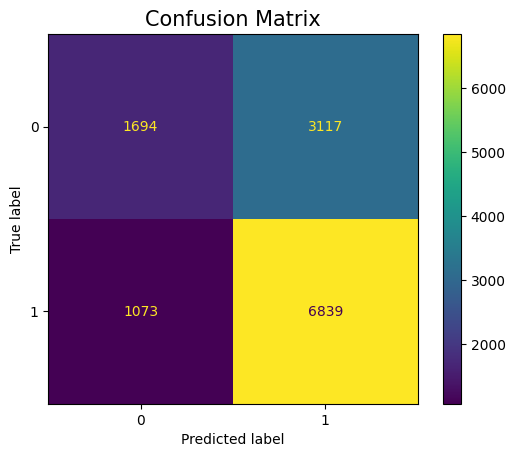

In [209]:
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=clf.classes_)
display.plot()
plt.title('Confusion Matrix', fontsize=15)
plt.show()

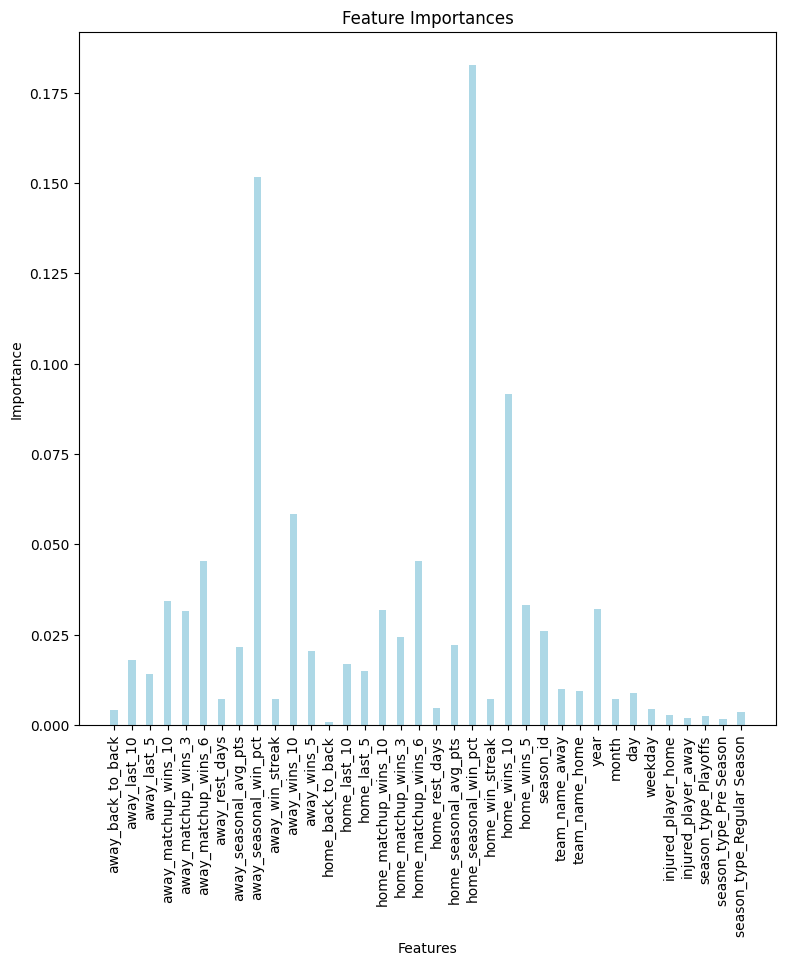

In [210]:
importances = clf.feature_importances_
features = X.columns.to_list()

plt.figure(figsize=(9, 9))
plt.title("Feature Importances")

bar = plt.bar(features, importances, color ='lightblue', width = 0.4)

plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

### XG Boost

In [211]:
# model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     use_label_encoder=False
# )

# model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     use_label_encoder=False,
#     learning_rate=0.05,
#     n_estimators=500,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     gamma=1,
#     min_child_weight=5,
#     alpha=0.5,
# )

# xg = xgb.XGBClassifier(
#     n_estimators=500,
#     max_depth=6,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     gamma=1,
#     alpha=0.5,
#     lambda_=1,
#     min_child_weight=5,
#     scale_pos_weight=1,
#     random_state=42,
#     use_label_encoder=False,
#     eval_metric='logloss'
# )

xg = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.01,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=2,
    alpha=0.5,
    lambda_=1,
    min_child_weight=10,
    scale_pos_weight=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)


xg.fit(X_train, y_train)

y_pred = xg.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:28:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "lambda_", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [212]:
train_score = xg.score(X_train, y_train)
print("Train Score:", train_score)
test_score = xg.score(X_test, y_test)
print("Test Score:", test_score)

Train Score: 0.6873968403678378
Test Score: 0.6741334590898374


In [213]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(round(accuracy * 100, 2)) + "%")

Accuracy: 67.41%


[[1992 2819]
 [1327 6585]]


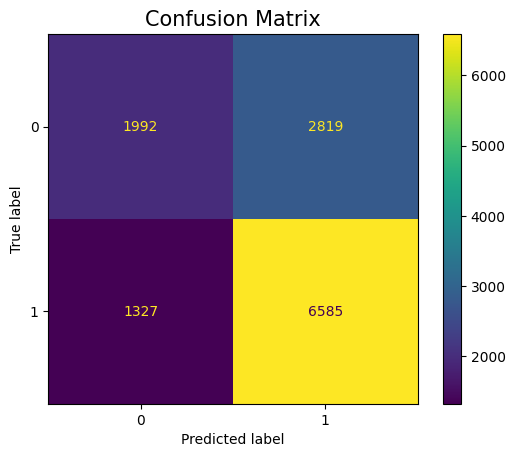

In [214]:
print(confusion_matrix(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=clf.classes_)
display.plot()
plt.title('Confusion Matrix', fontsize=15)
plt.show()

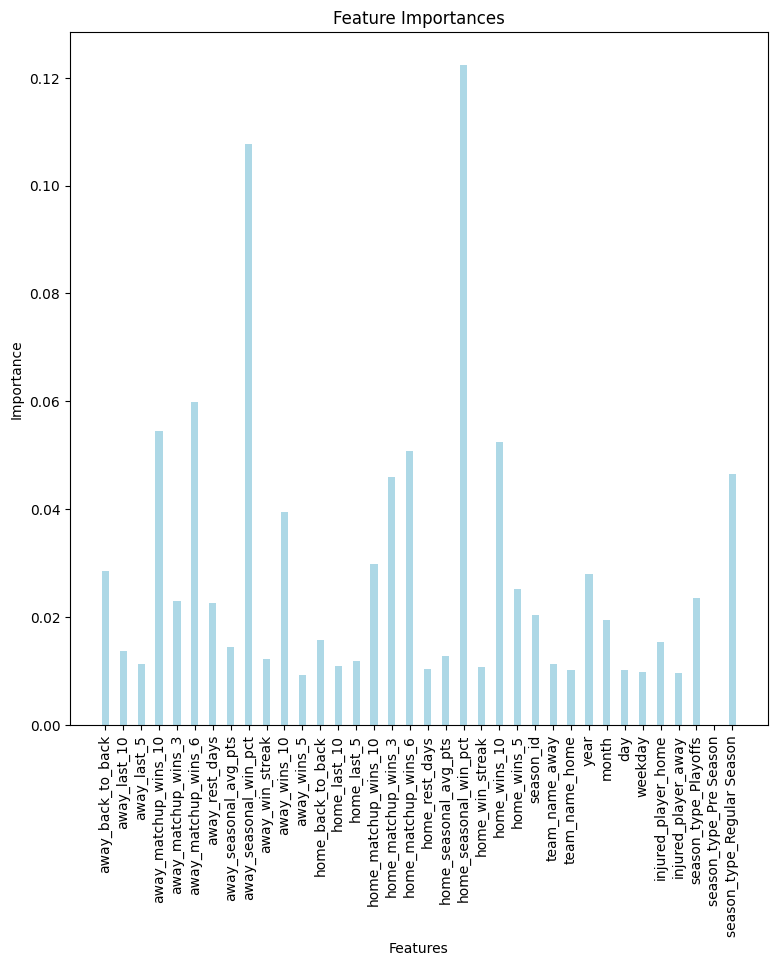

In [215]:
importances = xg.feature_importances_
features = X.columns.to_list()

plt.figure(figsize=(9, 9))
plt.title("Feature Importances")

bar = plt.bar(features, importances, color ='lightblue', width = 0.4)

plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

### Neural Net:

In [216]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [217]:
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


1273/1273 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - accuracy: 0.6131 - loss: 1.3858 - val_accuracy: 0.6650 - val_loss: 0.6380
Epoch 2/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.6507 - loss: 0.6483 - val_accuracy: 0.6677 - val_loss: 0.6359
Epoch 3/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.6534 - loss: 0.6432 - val_accuracy: 0.6679 - val_loss: 0.6319
Epoch 4/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.6558 - loss: 0.6428 - val_accuracy: 0.6662 - val_loss: 0.6303
Epoch 5/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.6516 - loss: 0.6410 - val_accuracy: 0.6688 - val_loss: 0.6316
Epoch 6/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - accuracy: 0.6538 - loss: 0.6416 - val_accuracy: 0.6673 - val_loss: 0.6288
Epoch 7/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.6561 - loss: 0.6392 - val_accuracy: 0.6631 - val_loss: 0.6284
Epoch 8/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.6558 - los

In [218]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

  2/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5547 - loss: 154.0940 

398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6244 - loss: 135.9924
Test Loss: 137.8270721435547
Test Accuracy: 0.6218659281730652
